In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils, grid_utils

import bootstrap_confidence

In [2]:
bootstrap_confidence.bootstrap_binary_hardtrials(n_boot_iter=1000, correct_only=False)

0
1
2
3
4
5
6


In [6]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)

    
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [9]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_bootstrap_correctonly.npy')
# fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_bootstrap.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

Text(0.5, 0.98, 'Centermost trials, mean +/- SEM across subjects')

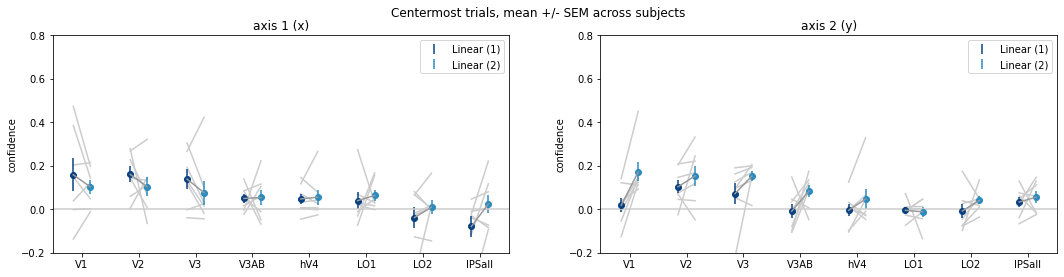

In [10]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))


for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, meanvals[:,ti,ii], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti,ii], \
                         semvals[:,ti,ii], \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
        plt.plot(ri+x_jitter, vals[:,ri,:,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
#         if non_overlapping[ri]:
#             yval = np.max(cihigh[ri,:,ii])+0.02
#             plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.80])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, mean +/- SEM across subjects')


In [6]:
vals.shape

(7, 8, 2, 2)

In [13]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,:,ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)



Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       3.078105     7.0    42.0  0.0104
task      0.010130     1.0     6.0  0.9231
roi:task  1.136315     7.0    42.0  0.3594

Anova for confidence w/r/t axis 2 (y), hardest trials
            F Value  Num DF  Den DF  Pr > F
roi        4.684748     7.0    42.0  0.0006
task      10.080206     1.0     6.0  0.0192
roi:task   1.211724     7.0    42.0  0.3178


In [14]:
ii = 1

vals = np.mean(signedconf_hardtrials_boot, axis=4)

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 345465
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0,ii]
    t2_values = vals[:,rr,1,ii]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

p_values = pvals_nonpar_task
   
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                        'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-3.688,0.033,6
V2,-1.099,0.283,5
V3,-1.571,0.057,6
V3AB,-1.518,0.195,5
hV4,-1.305,0.247,4
LO1,0.204,0.934,5
LO2,-1.143,0.327,5
IPSall,-0.535,0.595,4


In [15]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)

anova_table =  stats_utils.rmanova_3way(vals, ['roi','task','class_axis'], do_shuffle=False)                            

anova_table['Pr > F'] = anova_table['Pr > F'].round(4)

print(anova_table)

                      F Value  Num DF  Den DF  Pr > F
roi                  4.855695     7.0    42.0  0.0004
task                 6.443249     1.0     6.0  0.0442
class_axis           0.129682     1.0     6.0  0.7311
roi:task             0.427727     7.0    42.0  0.8794
roi:class_axis       1.349981     7.0    42.0  0.2517
task:class_axis      6.001544     1.0     6.0  0.0498
roi:task:class_axis  2.072016     7.0    42.0  0.0681


In [30]:
import copy

vals = np.mean(signedconf_hardtrials_boot, axis=4)

class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'task': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'class_axis': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

class_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(2):
            inds = (class_df['subject']==si) & (class_df['roi']==ri) & (class_df['task']==ti)
            # print(np.sum(inds))
            class_values[inds] = vals[si,ri,ti,:]
class_df['class_values'] = class_values

model = AnovaRM(data=class_df, \
                depvar='class_values', \
                subject='subject', \
                within = ['roi','task','class_axis'],
               )
rm_result = model.fit()
print(rm_result)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
roi                  4.8557 7.0000 42.0000 0.0004
task                 6.4432 1.0000  6.0000 0.0442
class_axis           0.1297 1.0000  6.0000 0.7311
roi:task             0.4277 7.0000 42.0000 0.8794
roi:class_axis       1.3500 7.0000 42.0000 0.2517
task:class_axis      6.0015 1.0000  6.0000 0.0498
roi:task:class_axis  2.0720 7.0000 42.0000 0.0681



#### Two-way RM Anova, for each type of decoding
[ROI x task]

In [31]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,:,ii]

    class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2), \
                               'roi': np.tile(np.repeat(np.arange(n_rois), 2),[n_subjects,]), \
                               'task': np.tile(np.arange(2), [n_subjects*n_rois,])})

    class_values = np.zeros((n_subjects*n_rois*2))
    for si in range(n_subjects):
        for ri in range(n_rois):
            inds = (class_df['subject']==si) & (class_df['roi']==ri)
            class_values[inds] = vals[si,ri,:]
    class_df['class_values'] = class_values

    model = AnovaRM(data=class_df, \
                    depvar='class_values', \
                    subject='subject', \
                    within = ['roi','task'],
                   )
    rm_result = model.fit()
    print('Classify %s'%axis_name)
    print(rm_result)

Classify axis 1 (x)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi       3.0781 7.0000 42.0000 0.0104
task      0.0101 1.0000  6.0000 0.9231
roi:task  1.1363 7.0000 42.0000 0.3594

Classify axis 2 (y)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi       4.6847 7.0000 42.0000 0.0006
task     10.0802 1.0000  6.0000 0.0192
roi:task  1.2117 7.0000 42.0000 0.3178



Medium trials - do individual ROIs show a task difference?

In [25]:
ii = 1
vals = np.mean(signedconf_hardtrials_boot, axis=4)

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 4656757
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0,ii]
    t2_values = vals[:,rr,1,ii]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_task
p_values = pvals_nonpar_task
# orig_shape = p_values.shape
# mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
#                                                                 alpha=0.01)
# mask_fdr = np.reshape(mask_fdr, orig_shape)
# pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           # 'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
# mask_fdr_vert = mask_fdr
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-3.688,0.033,6
V2,-1.099,0.276,5
V3,-1.571,0.062,6
V3AB,-1.518,0.210,5
hV4,-1.305,0.265,4
LO1,0.204,0.949,5
LO2,-1.143,0.334,5
IPSall,-0.535,0.588,4


Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

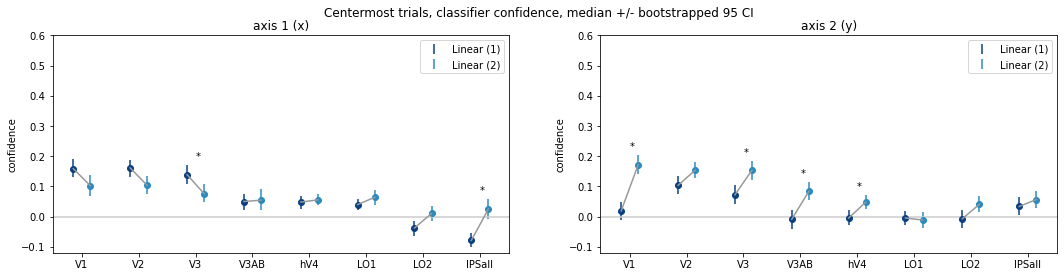

In [7]:
boot_vals = signedconf_hardtrials_boot
# average over subjects (within each bootstrapping iteration)
boot_vals_avg = np.mean(boot_vals, axis=0)
# get percentiles of the bootstrapped distrib
boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=3)
med = boot_pct[1]
cilow = boot_pct[0]
cihigh = boot_pct[2]


x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))



for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, med[:,ti,ii], 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, med[:,ti,ii], \
                         np.array([med[:,ti,ii]-cilow[:,ti,ii], cihigh[:,ti,ii] - med[:,ti,ii]]), \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, med[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
        if non_overlapping[ri]:
            yval = np.max(cihigh[ri,:,ii])+0.02
            plt.annotate('*',[ri,yval])

    plt.ylim([-0.12, 0.60])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')


#### Compare classification acc on the hardest trials between tasks
need to use bootstrapping here because trial counts/images are not the same between tasks

In [8]:
boot_vals = signedconf_hardtrials_boot
# average over subjects (within each bootstrapping iteration)
boot_vals_avg = np.mean(boot_vals, axis=0)
# get percentiles of the bootstrapped distrib
boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=3)
med = boot_pct[1]
cilow = boot_pct[0]
cihigh = boot_pct[2]

In [9]:
ii=0;

non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

pd.DataFrame(data={'task 1: median': med[:,0,ii].round(3), \
                  'task 2: median': med[:,1,ii].round(3), \
                  'task diff': (med[:,0,ii]-med[:,1,ii]).round(3), \
                  'CI non-overlapping': non_overlapping})

,task 1: median,task 2: median,task diff,CI non-overlapping
0,0.158,0.102,0.056,False
1,0.161,0.103,0.058,False
2,0.139,0.076,0.063,True
3,0.050,0.054,-0.004,False
4,0.048,0.055,-0.007,False
5,0.040,0.064,-0.024,False
6,-0.038,0.010,-0.048,False
7,-0.079,0.025,-0.104,True


In [10]:
ii=1;

non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

pd.DataFrame(data={'task 1: median': med[:,0,ii].round(3), \
                  'task 2: median': med[:,1,ii].round(3), \
                  'task diff': (med[:,0,ii]-med[:,1,ii]).round(3), \
                  'CI non-overlapping': non_overlapping})

,task 1: median,task 2: median,task diff,CI non-overlapping
0,0.019,0.172,-0.153,True
1,0.103,0.153,-0.050,False
2,0.072,0.153,-0.081,True
3,-0.009,0.083,-0.092,True
4,-0.005,0.047,-0.052,True
5,-0.005,-0.011,0.007,False
6,-0.007,0.040,-0.048,False
7,0.033,0.056,-0.023,False


In [41]:
median_vals.shape

(8, 2, 2)

#### Plot the actual coordinates that are used in this resampling procedure
checking that there is nothing super weird about the distribution

0
37 33
37 33
1
30 32
30 32
2
36 35
36 35
3
29 42
29 42
4
29 28
29 28
5
13 22
13 22
6
22 45
22 45


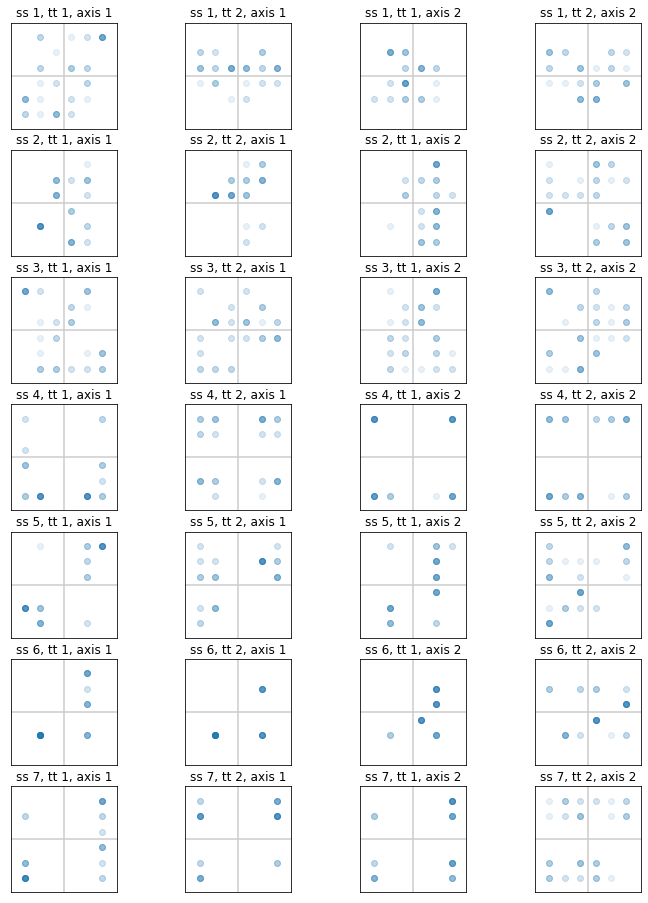

In [105]:
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_samp = 50; # how many total samples to take per bootstrap iteration?

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over "axes" - which boundary to compute accuracy for
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        correct = np.array(l['subject_correct'])
        
        # using only the trials in center of grid
        # (these are hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

        # actual label along the axis of interest
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # actual coordinate along the axis of interest
        coord_actual = pt_labs[:,ii].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & correct & (task_labs==1))[0]
        inds2 = np.where(is_hard & correct & (task_labs==2))[0]
        print(len(inds1), len(inds2))
        
        
        # figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

#         print(un1, counts1)
#         print(un2, counts2)
#         print(bin_dist[un1], bin_dist[un2])

        
        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            # to use this this bin, both this bin and the one opposite it (across the 
            # boundary) have to be sampled in both tasks
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        # print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # decide how many samples per bin, based on how many bins we have
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        
        # actual coordinate along the axis of interest
        coord_other = pt_labs[:,(1-ii)].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_other_binned = np.zeros(coord_other.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_other>=coord_bin_edges[cb]) & (coord_other<=coord_bin_edges[cb+1])
            coord_other_binned[binds] = cb
        assert(np.all(coord_other_binned[is_hard]>-1))
        
        
        
        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        coord_other_binned_all = coord_other_binned
        correct_all = correct
        
        # loop over the tasks
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            coord_other_binned = coord_other_binned_all[task_labs==tt]
            correct = correct_all[task_labs==tt]
            
            
            inds = np.where(is_hard & correct)[0]
            
            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)

            # double check resample order
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))

            pi+=1
            plt.subplot(n_subjects, 4, pi)
            if ii==0:
                plt.plot(bin_centers[coord_binned[inds_resamp]], \
                         bin_centers[coord_other_binned[inds_resamp]],'o',alpha=0.1)
            else:
                plt.plot(bin_centers[coord_other_binned[inds_resamp]], \
                         bin_centers[coord_binned[inds_resamp]],'o',alpha=0.1)
            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss %d, tt %d, axis %d'%(ss, tt,ii+1))
            plt.xlim([2.5-0.8, 2.5+0.8])
            plt.ylim([2.5-0.8, 2.5+0.8])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
#                

In [106]:
# create a set of bins for the shape-space coordinates that are sampled
# these only span the "hard" part of coordinate space
n_coord_bins = 6;
# n_coord_bins = 4;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_iter = 1000;
# n_boot_iter=2;

n_boot_samp = 50;
# n_boot_samp = 100; # how many total samples to take per bootstrap iteration?

# [subjects, rois, tasks, axes, bootstrap iterations]
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over "axes" - which boundary to compute accuracy for
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # correct = np.array(l['subject_correct'])
        
        # using only the trials in center of grid
        # (these are hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

        # actual label along the axis of interest
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # actual coordinate along the axis of interest
        coord_actual = pt_labs[:,ii].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        
        print(len(inds1), len(inds2))
        
        # figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        # print(un1, counts1)
        # print(un2, counts2)
        # print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            # to use this this bin, both this bin and the one opposite it (across the 
            # boundary) have to be sampled in both tasks
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        # print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # decide how many samples per bin, based on how many bins we have
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        # correct_all = correct
        
        # loop over the tasks
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            # correct = correct_all[task_labs==tt]
            
            inds = np.where(is_hard)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    # if bi==0:
                    #     print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # double check resample order
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # loop over ROIs
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    # which binary category did the classifier predict?
                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]                    
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
59 59
59 59
1
49 58
49 58
2
61 53
61 53
3
55 56
55 56
4
42 50
42 50
5
38 45
38 45
6
56 61
56 61


Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

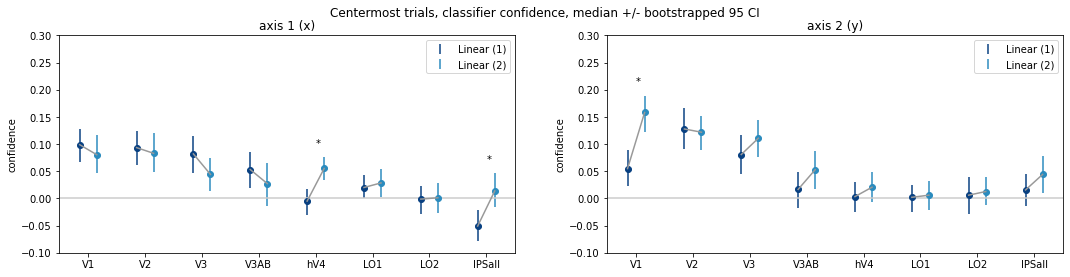

In [108]:
boot_vals = signedconf_hardtrials_boot
# average over subjects (within each bootstrapping iteration)
boot_vals_avg = np.mean(boot_vals, axis=0)
# get percentiles of the bootstrapped distrib
boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=3)
med = boot_pct[1]
cilow = boot_pct[0]
cihigh = boot_pct[2]


x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))



for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, med[:,ti,ii], 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, med[:,ti,ii], \
                         np.array([med[:,ti,ii]-cilow[:,ti,ii], cihigh[:,ti,ii] - med[:,ti,ii]]), \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, med[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
        if non_overlapping[ri]:
            yval = np.max(cihigh[ri,:,ii])+0.02
            plt.annotate('*',[ri,yval])

    plt.ylim([-0.1, 0.3])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')


#### Plot the actual coordinates that are used in this resampling procedure
checking that there is nothing super weird about the distribution

0
1
2
3
4
5
6


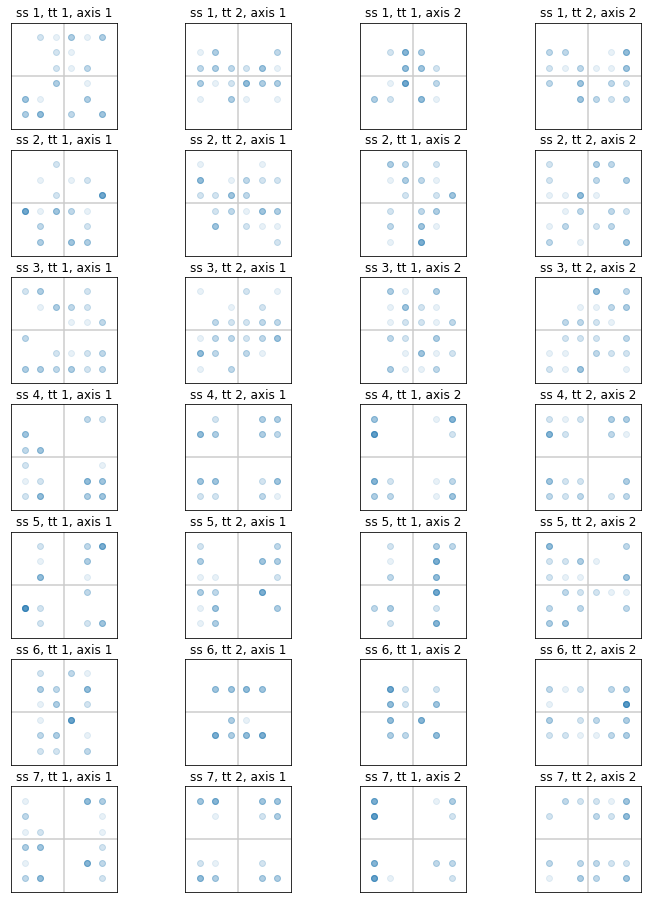

In [109]:
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_samp = 50; # how many total samples to take per bootstrap iteration?

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over "axes" - which boundary to compute accuracy for
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # correct = np.array(l['subject_correct'])
        
        # using only the trials in center of grid
        # (these are hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

        # actual label along the axis of interest
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # actual coordinate along the axis of interest
        coord_actual = pt_labs[:,ii].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        
        # figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

#         print(un1, counts1)
#         print(un2, counts2)
#         print(bin_dist[un1], bin_dist[un2])

        
        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            # to use this this bin, both this bin and the one opposite it (across the 
            # boundary) have to be sampled in both tasks
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        # print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # decide how many samples per bin, based on how many bins we have
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        
        # actual coordinate along the axis of interest
        coord_other = pt_labs[:,(1-ii)].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_other_binned = np.zeros(coord_other.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_other>=coord_bin_edges[cb]) & (coord_other<=coord_bin_edges[cb+1])
            coord_other_binned[binds] = cb
        assert(np.all(coord_other_binned[is_hard]>-1))
        
        
        
        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        coord_other_binned_all = coord_other_binned
        # correct_all = correct
        
        # loop over the tasks
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            coord_other_binned = coord_other_binned_all[task_labs==tt]
            # correct = correct_all[task_labs==tt]
            
            
            inds = np.where(is_hard)[0]
            
            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)

            # double check resample order
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))

            pi+=1
            plt.subplot(n_subjects, 4, pi)
            if ii==0:
                plt.plot(bin_centers[coord_binned[inds_resamp]], \
                         bin_centers[coord_other_binned[inds_resamp]],'o',alpha=0.1)
            else:
                plt.plot(bin_centers[coord_other_binned[inds_resamp]], \
                         bin_centers[coord_binned[inds_resamp]],'o',alpha=0.1)
            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss %d, tt %d, axis %d'%(ss, tt,ii+1))
            plt.xlim([2.5-0.8, 2.5+0.8])
            plt.ylim([2.5-0.8, 2.5+0.8])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
#                

#### below is old code for other ways of doing this

0
[0 1 2 3 4] [2 8 7 2 2]
[0 1 2 3 4 5] [2 1 2 3 1 3]
[ 0.58  0.35  0.12 -0.12 -0.35] [ 0.58  0.35  0.12 -0.12 -0.35 -0.58]
[ 0.35  0.12 -0.12 -0.35]
[0 1 2 3 4 5] [10  3  4  3  2  2]
[1 2 3 4] [ 1  4 10  2]
[ 0.58  0.35  0.12 -0.12 -0.35 -0.58] [ 0.35  0.12 -0.12 -0.35]
[ 0.35  0.12 -0.12 -0.35]
[1 2 3 4 5] [4 3 6 2 1]
[0 1 2 3 4 5] [5 3 4 2 2 5]
[ 0.35  0.12 -0.12 -0.35 -0.58] [ 0.58  0.35  0.12 -0.12 -0.35 -0.58]
[ 0.35  0.12 -0.12 -0.35]
[0 1 2 3 5] [1 2 1 4 5]
[1 2 3 4] [1 6 7 2]
[ 0.58  0.35  0.12 -0.12 -0.58] [ 0.35  0.12 -0.12 -0.35]
[ 0.12 -0.12]
1
[1 3 4] [ 1  8 10]
[0 3 4 5] [1 2 1 3]
[ 0.35 -0.12 -0.35] [ 0.58 -0.12 -0.35 -0.58]
[1 3 4] [1 1 1]
[2 3 4 5] [1 5 7 1]
[ 0.35 -0.12 -0.35] [ 0.12 -0.12 -0.35 -0.58]
[2 3 4 5] [2 2 6 1]
[0 1 2 3 4 5] [8 1 4 6 3 3]
[ 0.12 -0.12 -0.35 -0.58] [ 0.58  0.35  0.12 -0.12 -0.35 -0.58]
[ 0.12 -0.12]
[0 1 2 3 4 5] [11  3  4  3  4  2]
[0 1 3 4 5] [2 4 2 8 2]
[ 0.58  0.35  0.12 -0.12 -0.35 -0.58] [ 0.58  0.35 -0.12 -0.35 -0.58]
[ 0.58  0.35 -0

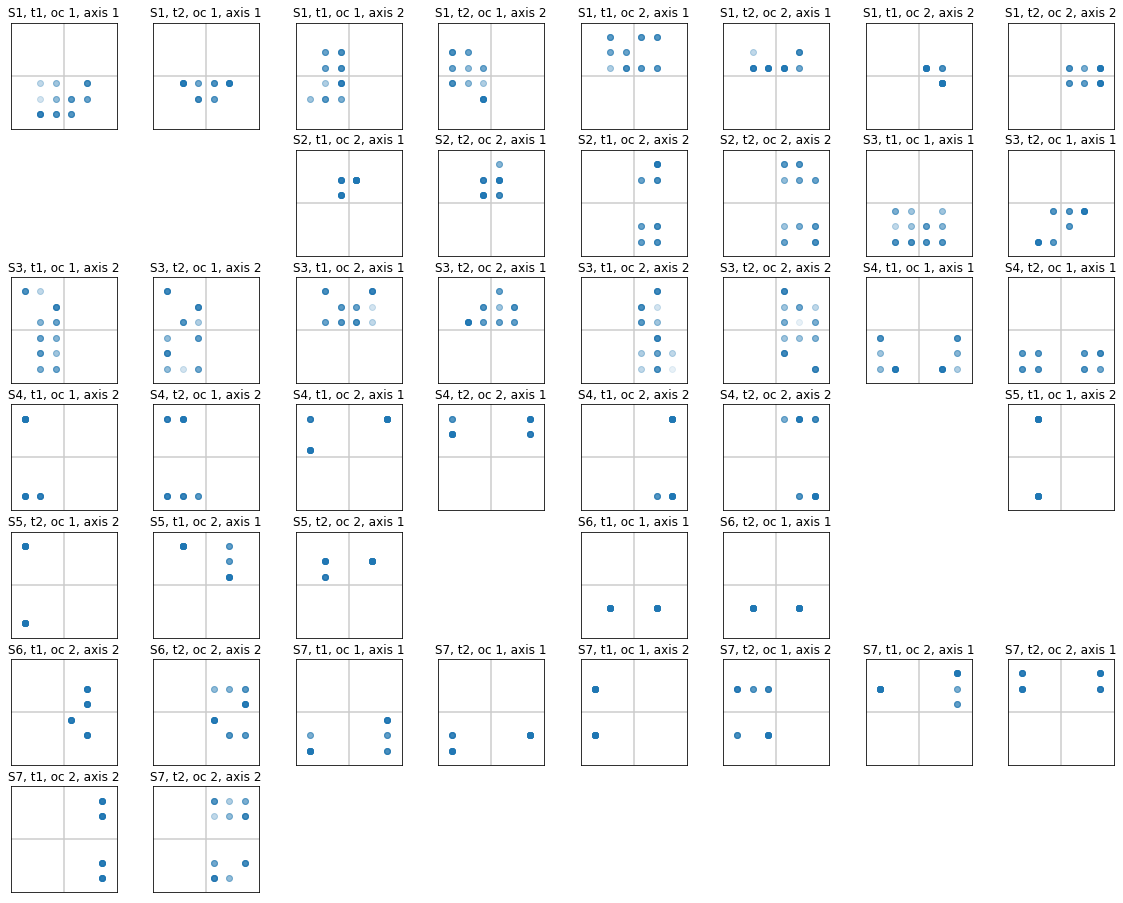

In [31]:
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_samp = 100; # how many total samples to take per bootstrap iteration?

plt.figure(figsize=(20,16))
pi=0;

# for si, ss in enumerate([1,3,4,5,6,7]):
for si, ss in enumerate(subjects):

    print(si)
    
    for oc in [1,2]:


        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            l = lab[ss]

            task_labs = l['task']

            pt_labs = np.array([l['ptx'], l['pty']]).T

            is_main_grid = l['is_main_grid']==1

            correct = np.array(l['subject_correct'])

            # using only the trials in center of grid
            # (these are hard for all the tasks)
            dist_from_center1 = l['dist_from_bound1']
            dist_from_center2 = l['dist_from_bound2']
            is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

            # actual label along the axis of interest
            categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)

            categ_other = np.array(l['categ_task%d'%(1-ii+1)]).astype(int)
            other_categ = (categ_other==oc)
            assert(np.mean(other_categ)==0.5)
            
            # actual coordinate along the axis of interest
            coord_actual = pt_labs[:,ii].round(2)

            # break the coordinate axis into bins, use these to balance the stimulus
            # distribution when bootstrapping
            coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
            for cb in np.arange(n_coord_bins):
                binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
                coord_binned[binds] = cb
            assert(np.all(coord_binned[is_hard]>-1))

            inds1 = np.where(is_hard & correct & other_categ & (task_labs==1))[0]
            inds2 = np.where(is_hard & correct & other_categ & (task_labs==2))[0]

            # figure out which bins we can use and still have everything balanced in both tasks
            un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
            un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

            print(un1, counts1)
            print(un2, counts2)
            print(bin_dist[un1], bin_dist[un2])


            bins_balance = []
            for uu in np.union1d(un1, un2):
                d = bin_dist[uu]
                # to use this this bin, both this bin and the one opposite it (across the 
                # boundary) have to be sampled in both tasks
                in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
                in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
                if in1 and in2:
                    bins_balance += [uu]
                    
            if len(bins_balance)==0:
                pi+=1
                continue
            print(bin_dist[bins_balance])

            # checking that the bins we are using represent each category equally
            assert(np.mean(bin_dist[bins_balance]<0)==0.5)

            # decide how many samples per bin, based on how many bins we have
            n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))


            # actual coordinate along the axis of interest
            coord_other = pt_labs[:,(1-ii)].round(2)

            # break the coordinate axis into bins, use these to balance the stimulus
            # distribution when bootstrapping
            coord_other_binned = np.zeros(coord_other.shape, dtype=int)-1
            for cb in np.arange(n_coord_bins):
                binds = (coord_other>=coord_bin_edges[cb]) & (coord_other<=coord_bin_edges[cb+1])
                coord_other_binned[binds] = cb
            assert(np.all(coord_other_binned[is_hard]>-1))



            is_hard_all = is_hard
            coord_binned_all = coord_binned
            categ_actual_all = categ_actual
            coord_other_binned_all = coord_other_binned
            correct_all = correct
            other_categ_all = other_categ

            # loop over the tasks
            for ti,tt in enumerate([1,2]):

                is_hard = is_hard_all[task_labs==tt]
                coord_binned = coord_binned_all[task_labs==tt]
                categ_actual = categ_actual_all[task_labs==tt]
                coord_other_binned = coord_other_binned_all[task_labs==tt]
                correct = correct_all[task_labs==tt]
                other_categ = other_categ_all[task_labs==tt]

                inds = np.where(is_hard & correct & other_categ)[0]

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    # if bi==0:
                    #     print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)

                # double check resample order
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))

                pi+=1
                plt.subplot(n_subjects, 8, pi)
                if ii==0:
                    plt.plot(bin_centers[coord_binned[inds_resamp]], \
                             bin_centers[coord_other_binned[inds_resamp]],'o',alpha=0.1)
                else:
                    plt.plot(bin_centers[coord_other_binned[inds_resamp]], \
                             bin_centers[coord_binned[inds_resamp]],'o',alpha=0.1)
                plt.axis('square')
                plt.xticks([]); plt.yticks([])
                plt.title('S%d, t%d, oc %d, axis %d'%(ss, tt, oc, ii+1))
                plt.xlim([2.5-0.8, 2.5+0.8])
                plt.ylim([2.5-0.8, 2.5+0.8])
                plt.axhline(2.5, color=[0.8, 0.8, 0.8])
                plt.axvline(2.5, color=[0.8, 0.8, 0.8])
    #                

In [23]:
np.mean(categ_actual[inds_resamp]==1)

0.59

In [95]:
# create a set of bins for the shape-space coordinates that are sampled
# these only span the "hard" part of coordinate space
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_iter = 1000;
# n_boot_iter=2;

n_boot_samp = 100; # how many total samples to take per bootstrap iteration?

# [subjects, rois, tasks, axes, bootstrap iterations]
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over "axes" - which boundary to compute accuracy for
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # using only the trials in center of grid
        # (these are hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

        # actual label along the axis of interest
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # actual coordinate along the axis of interest
        coord_actual = pt_labs[:,ii].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        
        # figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        # print(un1, counts1)
        # print(un2, counts2)
        # print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            # to use this this bin, both this bin and the one opposite it (across the 
            # boundary) have to be sampled in both tasks
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        # print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # decide how many samples per bin, based on how many bins we have
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        
        # loop over the tasks
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            
            
            inds = np.where(is_hard)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    # if bi==0:
                    #     print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # double check resample order
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # loop over ROIs
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    # which binary category did the classifier predict?
                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]                    
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
1
2
3
4
5
6


0
1
2
3
4
5
6


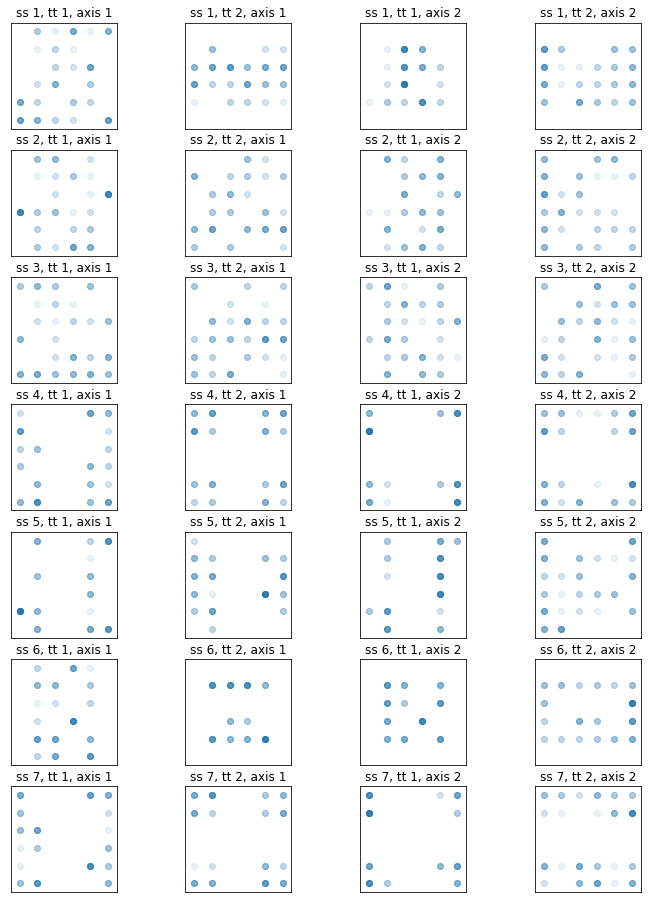

In [110]:
# create a set of bins for the shape-space coordinates that are sampled
# these only span the "hard" part of coordinate space
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

# n_boot_iter = 1000;
n_boot_iter=2;

n_boot_samp = 100; # how many total samples to take per bootstrap iteration?

# # [subjects, rois, tasks, axes, bootstrap iterations]
# dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
# signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over "axes" - which boundary to compute accuracy for
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # using only the trials in center of grid
        # (these are hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

        # actual label along the axis of interest
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # actual coordinate along the axis of interest
        coord_actual = pt_labs[:,ii].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        
        # figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        # print(un1, counts1)
        # print(un2, counts2)
        # print(bin_dist[un1], bin_dist[un2])

        
        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            # to use this this bin, both this bin and the one opposite it (across the 
            # boundary) have to be sampled in both tasks
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        # print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # decide how many samples per bin, based on how many bins we have
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        
        # actual coordinate along the axis of interest
        coord_other = pt_labs[:,(1-ii)].round(2)
        
        # break the coordinate axis into bins, use these to balance the stimulus
        # distribution when bootstrapping
        coord_other_binned = np.zeros(coord_other.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_other>=coord_bin_edges[cb]) & (coord_other<=coord_bin_edges[cb+1])
            coord_other_binned[binds] = cb
        assert(np.all(coord_other_binned[is_hard]>-1))
        
        
        
        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        coord_other_binned_all = coord_other_binned
        
        
        # loop over the tasks
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            coord_other_binned = coord_other_binned_all[task_labs==tt]
            
            inds = np.where(is_hard)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    # if bi==0:
                    #     print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # double check resample order
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                if bi==0:
                    pi+=1
                    plt.subplot(n_subjects, 4, pi)
                    if ii==0:
                        plt.plot(coord_binned[inds_resamp], coord_other_binned[inds_resamp],'o',alpha=0.1)
                    else:
                        plt.plot(coord_other_binned[inds_resamp], coord_binned[inds_resamp],'o',alpha=0.1)
                    plt.axis('square')
                    plt.xticks([]); plt.yticks([])
                    plt.title('ss %d, tt %d, axis %d'%(ss, tt,ii+1))
                    plt.xlim([-0.5, 5.5])
                    plt.ylim([-0.5, 5.5])
#                

In [139]:
# create a set of bins for the shape-space coordinates that are sampled
# these only span the "hard" part of coordinate space
n_coord_bins = 2;
# n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.701, 2.5+0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

# n_boot_iter = 1000;
n_boot_iter=2;

n_boot_samp = 100; # how many total samples to take per bootstrap iteration?

# # [subjects, rois, tasks, axes, bootstrap iterations]
# dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
# signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)
    
        
    l = lab[ss]

    task_labs = l['task']

    pt_labs = np.array([l['ptx'], l['pty']]).T

    is_main_grid = l['is_main_grid']==1

    correct = np.array(l['subject_correct'])

    # using only the trials in center of grid
    # (these are hard for all the tasks)
    dist_from_center1 = l['dist_from_bound1']
    dist_from_center2 = l['dist_from_bound2']
    is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79) & (~is_main_grid)

    # actual label along the axis of interest
    categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)

    # actual coordinate along the axis of interest
    coord_actual1 = pt_labs[:,0].round(2)
    coord_actual2 = pt_labs[:,1].round(2)

    # break the coordinate axis into bins, use these to balance the stimulus
    # distribution when bootstrapping
    coord_binned = np.zeros(coord_actual1.shape, dtype=int)-1
    cx = -1
    for cb1 in np.arange(n_coord_bins):
        for cb2 in np.arange(n_coord_bins):
            binds = (coord_actual1>=coord_bin_edges[cb1]) & (coord_actual1<=coord_bin_edges[cb1+1]) \
                    & (coord_actual2>=coord_bin_edges[cb2]) & (coord_actual2<=coord_bin_edges[cb2+1])
            cx+=1
            coord_binned[binds] = cx
    assert(np.all(coord_binned[is_hard]>-1))

    inds1 = np.where(is_hard & correct & (task_labs==1))[0]
    inds2 = np.where(is_hard & correct & (task_labs==2))[0]

    # figure out which bins we can use and still have everything balanced in both tasks
    un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
    un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

    print(un1, counts1)
    print(un2, counts2)
    # print(bin_dist[un1], bin_dist[un2])

#     print()
#     assert(len(un1)==4)
#     assert(len(un2)==4)
    
    bins_balance = [0,1,2,3]

#     # print(bin_dist[bins_balance])

#     # checking that the bins we are using represent each category equally
#     assert(np.mean(bin_dist[bins_balance]<0)==0.5)

#     # decide how many samples per bin, based on how many bins we have
#     n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))


#     # actual coordinate along the axis of interest
#     coord_other = pt_labs[:,(1-ii)].round(2)

#     # break the coordinate axis into bins, use these to balance the stimulus
#     # distribution when bootstrapping
#     coord_other_binned = np.zeros(coord_other.shape, dtype=int)-1
#     for cb in np.arange(n_coord_bins):
#         binds = (coord_other>=coord_bin_edges[cb]) & (coord_other<=coord_bin_edges[cb+1])
#         coord_other_binned[binds] = cb
#     assert(np.all(coord_other_binned[is_hard]>-1))



#     is_hard_all = is_hard
#     coord_binned_all = coord_binned
#     categ_actual_all = categ_actual
#     coord_other_binned_all = coord_other_binned
#     correct_all = correct

#      # loop over "axes" - which boundary to compute accuracy for
#     for ii in [0,1]:

#         # loop over the tasks
#         for ti,tt in enumerate([1,2]):
            
#             is_hard = is_hard_all[task_labs==tt]
#             coord_binned = coord_binned_all[task_labs==tt]
#             categ_actual = categ_actual_all[task_labs==tt]
#             coord_other_binned = coord_other_binned_all[task_labs==tt]
#             correct = correct_all[task_labs==tt]
            
            
#             inds = np.where(is_hard & correct)[0]
            
#             for bi in range(n_boot_iter):

#                 # make a resampling order that represents each bin equally
#                 inds_resamp = []
#                 for bn in bins_balance:
#                     inds_bin = inds[coord_binned[inds]==bn]
#                     assert(len(inds_bin)>0)
#                     # if bi==0:
#                     #     print(len(inds_bin), n_samp_eachbin)
#                     inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
#                 inds_resamp = np.concatenate(inds_resamp, axis=0)
               
#                 # double check resample order
#                 assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
#                 assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
#                 counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
#                 assert(np.all(counts==n_samp_eachbin))
                
#                 if bi==0:
#                     pi+=1
#                     plt.subplot(n_subjects, 4, pi)
#                     if ii==0:
#                         plt.plot(bin_centers[coord_binned[inds_resamp]], \
#                                  bin_centers[coord_other_binned[inds_resamp]],'o',alpha=0.1)
#                     else:
#                         plt.plot(bin_centers[coord_other_binned[inds_resamp]], \
#                                  bin_centers[coord_binned[inds_resamp]],'o',alpha=0.1)
#                     plt.axis('square')
#                     plt.xticks([]); plt.yticks([])
#                     plt.title('ss %d, tt %d, axis %d'%(ss, tt,ii+1))
#                     plt.xlim([2.5-0.8, 2.5+0.8])
#                     plt.ylim([2.5-0.8, 2.5+0.8])
#                     plt.axhline(2.5, color=[0.8, 0.8, 0.8])
#                     plt.axvline(2.5, color=[0.8, 0.8, 0.8])
# #                

0
[0 1 2 3] [17  7  4  9]
[0 1 2 3] [ 5 12  7  9]
1
[0 1 2 3] [ 1  2 18  9]
[0 1 2 3] [ 1 13  6 12]
2
[0 1 2 3] [ 9  5 10 12]
[0 1 2 3] [ 9  6  8 12]
3
[0 1 2 3] [10  5 10  4]
[0 1 2 3] [12 11  9 10]
4
[0 1 2 3] [ 9  1  4 15]
[0 1 2 3] [ 7 12  1  8]
5
[0 2 3] [1 5 7]
[0 1 2 3] [3 7 3 9]
6
[0 1 2 3] [6 1 6 9]
[0 1 2 3] [ 8 13  6 18]


<Figure size 864x1152 with 0 Axes>

In [137]:
np.sum(task_labs==1)

480

In [152]:
l = lab[ss][lab[ss]['task']==1]
q = np.array(l['quadrant'])
is_hard = ~np.array(l['is_main_grid']==1)
np.unique(q[is_hard], return_counts=True)

(array([1, 2, 3, 4]), array([48, 48, 48, 48]))

In [135]:
counts1

array([1, 5, 7])

In [136]:
un2, counts2

(array([0, 1, 2, 3]), array([3, 7, 3, 9]))

In [107]:
np.unique(coord_binned)

array([-1,  0,  1,  4,  5])

Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

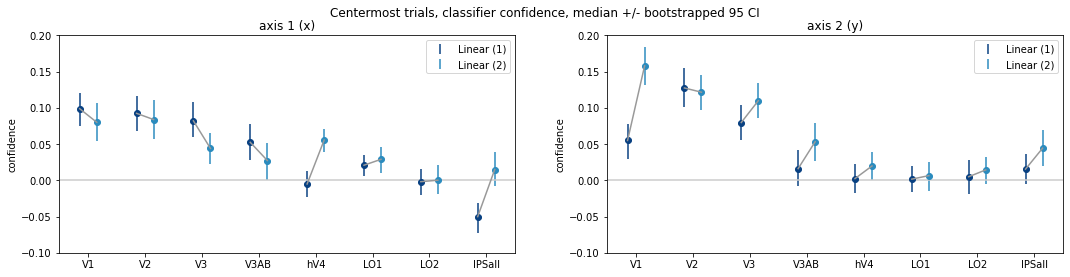

In [96]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))

for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    
    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ti, boot_vals in enumerate([signedconf_hardtrials_boot[:,:,0,ii,:], \
                                    signedconf_hardtrials_boot[:,:,1,ii,:]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.2])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')


#### Including Checkerboard task too

In [30]:
# n_coord_bins = 12;
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)


n_boot_iter = 1000;
# n_boot_iter=2;
n_boot_samp = 100;

# bootstrap the distribution of classifier accuracy on hard trials, 
# for each linear axis and two linear tasks.
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 3, 3, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 3, 3, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over two axes
    for ii in [0,1,2]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # dist_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        
        if ii<2:
            coord_actual = pt_labs[:,ii].round(2)
        else:
            coord_actual = np.array(l['dist_from_bound3'])
            coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]
            coord_actual += center
            
        # using only the trials in center of grid
        # (hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79)

        
        # going to use these to make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        inds3 = np.where(is_hard & (task_labs==3))[0]
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)
        un3, counts3 = np.unique(coord_binned[inds3], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
        print(un3, counts3)
    
        print(bin_dist[un1], bin_dist[un2], bin_dist[un3])

        bins_balance = []
        for uu in np.union1d(np.union1d(un1, un2), un3):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            in3 = (d in bin_dist[un3]) and (-d in bin_dist[un3])
            if in1 and in2 and in3:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        
        
        for ti,tt in enumerate([1,2,3]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            
            
            inds = np.where(is_hard)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # check that the set we created has half each category
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
            
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    pdiff = p_categ2 - p_categ1
                    
                    signedconf = np.zeros_like(pdiff)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
[1 2 3 4] [16 20 16  7]
[0 1 2 3 4 5] [13  6 12  8 12  8]
[0 1 4 5] [4 7 7 5]
[ 0.4   0.13 -0.13 -0.4 ] [ 0.67  0.4   0.13 -0.13 -0.4  -0.67] [ 0.67  0.4  -0.4  -0.67]
[ 0.4 -0.4]
16 50
7 50
6 50
12 50
7 50
7 50
[0 1 2 3 4 5] [10 12  8 11 10  8]
[1 2 3 4] [ 6 22 27  4]
[0 1 4 5] [ 2  6 13  2]
[ 0.67  0.4   0.13 -0.13 -0.4  -0.67] [ 0.4   0.13 -0.13 -0.4 ] [ 0.67  0.4  -0.4  -0.67]
[ 0.4 -0.4]
12 50
10 50
6 50
4 50
6 50
13 50
[1 2 3 4] [ 6 18 23 12]
[1 2 3 4] [ 4 29 23  3]
[1 4] [13 10]
[ 0.4   0.13 -0.13 -0.4 ] [ 0.4   0.13 -0.13 -0.4 ] [ 0.4 -0.4]
[ 0.4 -0.4]
6 50
12 50
4 50
3 50
13 50
10 50
1
[1 2 3 4] [11 11 10 17]
[0 1 2 3 4 5] [ 9 13  7 10  9 10]
[0 1 2 3 4] [ 4 19  2  3 11]
[ 0.4   0.13 -0.13 -0.4 ] [ 0.67  0.4   0.13 -0.13 -0.4  -0.67] [ 0.67  0.4   0.13 -0.13 -0.4 ]
[ 0.4   0.13 -0.13 -0.4 ]
11 25
11 25
10 25
17 25
13 25
7 25
10 25
9 25
19 25
2 25
3 25
11 25
[0 1 2 3 4 5] [ 8 13  8  5 10  5]
[1 2 3 4] [22 11  7 18]
[0 1 3 4 5] [ 5 14  1 15  4]
[ 0.67  0.4   0.13 -0.13 -0.4  -

Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

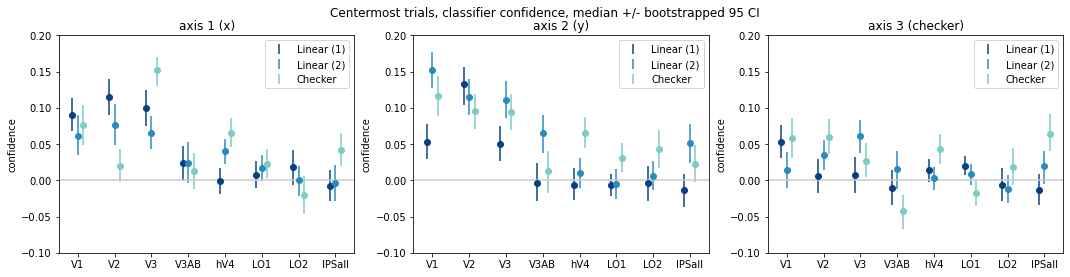

In [31]:
x_jitter = np.linspace(-0.15, 0.15, 3)

plt.figure(figsize=(18,4))

for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)','axis 3 (checker)']):

    
    plt.subplot(1,3,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ti, boot_vals in enumerate([signedconf_hardtrials_boot[:,:,0,ii,:], \
                                    signedconf_hardtrials_boot[:,:,1,ii,:],\
                                    signedconf_hardtrials_boot[:,:,2,ii,:]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
#     for ri in range(n_rois):
            
#         median_vals = [mtmp[0][ri], mtmp[1][ri]]
        # plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.2])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:3])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')


In [13]:
# n_coord_bins = 12;
n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)


n_boot_iter = 1000;
# n_boot_iter=2;
# n_boot_samp = 100;

# bootstrap the distribution of classifier accuracy on hard trials, 
# for each linear axis and two linear tasks.
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over two axes
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # dist_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # using only the trials in center of grid
        # (hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79)

        
        # going to use these to make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
    
        print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        
        counts1 = np.array([np.sum(coord_binned[inds1]==bb) for bb in bins_balance])

        counts2 = np.array([np.sum(coord_binned[inds2]==bb) for bb in bins_balance])

        n_samp_eachbin = np.minimum(counts1, counts2)
        
        # n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        is_hard_all = is_hard
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        
        
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            
            
            inds = np.where(is_hard)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bni, bn in enumerate(bins_balance):
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin[bni])
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin[bni], replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
                if bi==0:
                    print(len(inds_resamp))
                    print(np.mean(categ_actual[inds_resamp]==1))

                # check that the set we created has half each category
                # assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
            
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    pdiff = p_categ2 - p_categ1
                    
                    signedconf = np.zeros_like(pdiff)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
[1 2 3 4] [16 20 16  7]
[0 1 2 3 4 5] [13  6 12  8 12  8]
[ 0.4   0.13 -0.13 -0.4 ] [ 0.67  0.4   0.13 -0.13 -0.4  -0.67]
[ 0.4   0.13 -0.13 -0.4 ]
16 6
20 12
16 8
7 7
33
0.5454545454545454
6 6
12 12
8 8
12 7
33
0.5454545454545454
[0 1 2 3 4 5] [10 12  8 11 10  8]
[1 2 3 4] [ 6 22 27  4]
[ 0.67  0.4   0.13 -0.13 -0.4  -0.67] [ 0.4   0.13 -0.13 -0.4 ]
[ 0.4   0.13 -0.13 -0.4 ]
12 6
8 8
11 11
10 4
29
0.4827586206896552
6 6
22 8
27 11
4 4
29
0.4827586206896552
1
[1 2 3 4] [11 11 10 17]
[0 1 2 3 4 5] [ 9 13  7 10  9 10]
[ 0.4   0.13 -0.13 -0.4 ] [ 0.67  0.4   0.13 -0.13 -0.4  -0.67]
[ 0.4   0.13 -0.13 -0.4 ]
11 11
11 7
10 10
17 9
37
0.4864864864864865
13 11
7 7
10 10
9 9
37
0.4864864864864865
[0 1 2 3 4 5] [ 8 13  8  5 10  5]
[1 2 3 4] [22 11  7 18]
[ 0.67  0.4   0.13 -0.13 -0.4  -0.67] [ 0.4   0.13 -0.13 -0.4 ]
[ 0.4   0.13 -0.13 -0.4 ]
13 13
8 8
5 5
10 10
36
0.5833333333333334
22 13
11 8
7 5
18 10
36
0.5833333333333334
2
[1 2 3 4] [21 10  9 21]
[0 1 2 3 4 5] [ 9  6 10 12  7  9]
[ 0.4  

Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

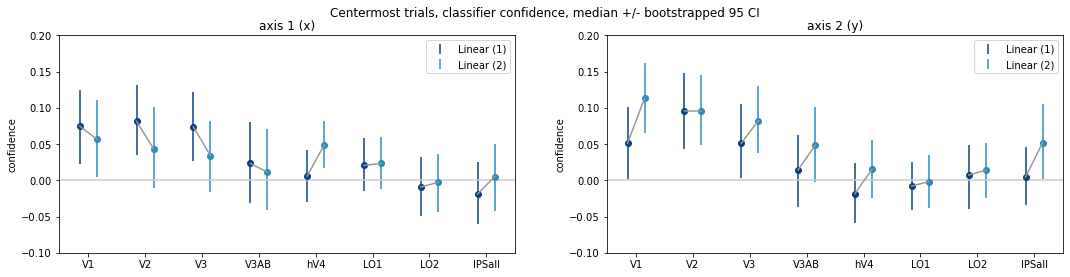

In [14]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))

for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    
    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ti, boot_vals in enumerate([signedconf_hardtrials_boot[:,:,0,ii,:], \
                                    signedconf_hardtrials_boot[:,:,1,ii,:]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.2])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')
